# Bubble Shear Test Case

As outlined in McManus et al(2017)[1] Section 5.1, there is an advection problem with a time-dependent velocity field that is periodic. The equation we solve is the pure scalar advection equation 
$$
\frac{\partial \mathbf{u}}{\partial t} + \nabla \cdot (\mathbf{c} u) = 0
$$

where $\mathbf{c}$ is defined as 
$$
c(x, y, t) = \begin{bmatrix}
2 \sin^2(\pi x) \sin(\pi y) \cos (\frac{\pi t}{2T}) \\
2\sin( \pi x) \sin^2(\pi y) \cos (\frac{\pi t}{2T}) \\
\end{bmatrix}
$$

At $t = 0$, $u = 0$ everywhere except in a ball (bubble) of radius $0.15$ centered in $(0.5, 0.8)$, which models a bubble and where u = 1. This bubble is sheared as per the advecting velocity field. 

In [1]:
from firedrake import *
from pyroteus import *
from pyroteus_adjoint import *
import matplotlib.pyplot as plt
from movement import *
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'  # Ensure  background on plots is white

T = Constant(3.000)
B_RADIUS = 0.1
B_X = 0.5
B_Y = 0.85


def apply_supg(test_function, c, unorm=1,  hds=1):
    """
    Apply SUPG stabilization in the sense of modifying the test function.
    """
    unorm = Constant(unorm)
    cellsize = CellSize(test_function.function_space().mesh())
    tau = 0.5*cellsize/unorm
    D = Constant(hds)
    Pe = 0.5*unorm*cellsize/D
    tau = conditional(D > 0, min_value(tau, Pe/3), tau)
    inc = tau*dot(c, grad(test_function))
    return test_function + conditional(unorm > 0, inc, 0)

def get_velocity(coords, t):
    x, y = coords
    return as_vector([
        2*sin(pi*x)*sin(pi*x)*sin(pi*y)*cos(pi*t/(2*T)),
        2*sin(pi*x)*sin(pi*y)*sin(pi*y)*cos(pi*t/(2*T))])


def get_bcs(mesh_seq):
    def bcs(index, field="u"):
        fs = mesh_seq.function_spaces[field][index]
        return [DirichletBC(fs, 0, "on_boundary")]

    return bcs

def get_form(mesh_seq):
    def form(index, solutions):
        u, u_ = solutions["u"]
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = Constant(P.timesteps[index])
        t = t_start + index * dt
        P1_vec = VectorFunctionSpace(u.function_space().mesh(), "CG", 1)
        c = Function(P1_vec, name="c")
        c.interpolate(get_velocity(SpatialCoordinate(P1_vec.mesh()), t))
#         v = TestFunction(u.function_space())
        v = apply_supg(TestFunction(u.function_space()), c)
        mesh = u.function_space().mesh()
        F = (
            inner((u - u_) / dt, v) * dx
            + inner(u * dot(c,  FacetNormal(mesh)), v) * ds
            - inner(u * c,  grad(v)) * dx
#             Before
#             + inner(dot(nabla_grad(u), c), v) * dx
#             + inner(dot(u, nabla_div(c)), v) * dx
        )
        return F

    return form


def get_solver(mesh_seq):
    def solver(index, ic):
        function_space = mesh_seq.function_spaces["u"][index]
        u = Function(function_space)
        u_ = Function(function_space, name="u_old")
        u_.assign(ic["u"])
        
        P1_vec = VectorFunctionSpace(u.function_space().mesh(), "CG", 1)
        c = Function(P1_vec, name="c")
        # Define form
        F = mesh_seq.form(index, {"u": (u, u_), "c": (c, )})
        # Time integrate from start to end
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = P.timesteps[index]
        t = t_start
        it  = 0
        while t < t_end - 1e-5:
            if it % 100 == 0:
                print(it)
            it += 1
            c.interpolate(get_velocity(SpatialCoordinate(P1_vec.mesh()), t))
            solve(F == 0, u, ad_block_tag="u")
            u_.assign(u)
            t += dt
        return {"u": u}

    return solver

def get_function_spaces(mesh,  field="u"):
    return {"u": FunctionSpace(mesh, "CG", 1),
            "c": VectorFunctionSpace(mesh, "CG", 1)}


def get_initial_condition(mesh_seq):
    fs = mesh_seq.function_spaces["u"][0]
    x, y = SpatialCoordinate(fs.mesh())
    c = conditional(le((x-B_X)**2 + (y-B_Y)**2, B_RADIUS**2), 1, 0)
    u = Function(fs, name='u_initial')
    u.interpolate(c)
    return {"u": u}


def get_qoi(mesh_seq, solutions, i):
    def end_time_qoi():
        u = solutions["u"]
        fs = u.function_space()
        x, y = SpatialCoordinate(fs.mesh())
        c = conditional(le((x-B_X)**2 + (y-B_Y)**2, B_RADIUS**2), 1, 0)
        ic = Function(fs)
        ic.interpolate(c)
        return inner((ic-u), (ic-u)) * dx
#         return inner(u, u) * dx

    
    dt = Constant(mesh_seq.time_partition[i].timestep)
    def time_integrated_qoi(t):
        u = solutions["u"]
        return dt * inner(u, u) * dx
        

    return end_time_qoi

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
n = 50
fields = ["u"]
mesh = UnitSquareMesh(n, n, diagonal='left')
meshes = [mesh]
end_time = 1.6
dt = 0.008
num_subintervals = len(meshes)
timesteps_per_export = int(end_time / dt) / 10
print("Timesteps per export: {}".format(timesteps_per_export))
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=timesteps_per_export,
)
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    get_bcs=get_bcs,
    qoi_type="end_time"
)
# solutions = mesh_seq.solve_forward()
solutions, indicators = mesh_seq.indicate_errors()
# print("QOI in forward solve: {:.5f}".format(mesh_seq.J))

Timesteps per export: 60.0
0
100
200
300
400
500
0
100
200
300
400
500


10
QOI in forward solve: 14057417468692142563266107345018603891707263762995659067906789562930521705049723876396088459681418679778600288256.00000
10.0
2 5


Text(0.5, 1.0, 'Forward solution')

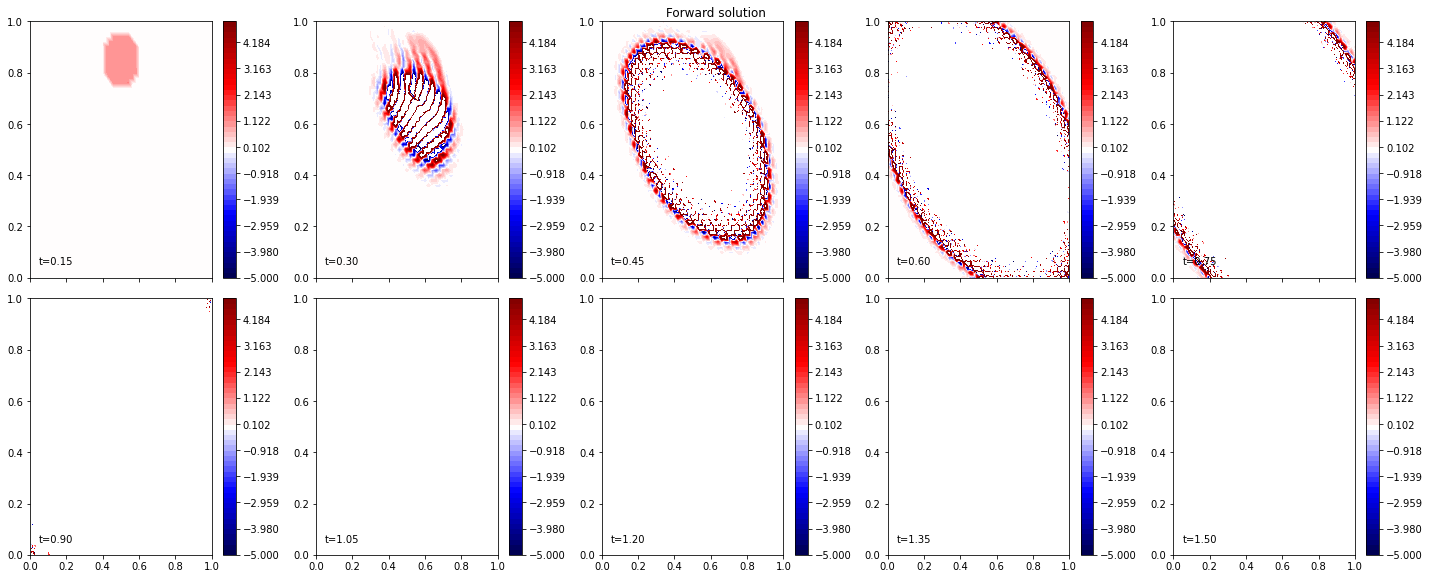

In [3]:
def plot_field(solutions, time_partition, field="u", label="forward", rows=None, cols=None, **kwargs):
    P = time_partition
    if rows is None or cols is None:
        rows = (P.exports_per_subinterval[0] - 1) // 2
        cols = (P.num_subintervals * 2)
    steady = rows == cols == 1
    print(rows, cols)
    dt = P.timesteps[0]
    figsize = kwargs.pop("figsize", (4 * cols, 4 * rows))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(solutions[field][label][0][idx], axes=ax, **kwargs))
            if not steady:
                time = (idx+1) * dt * timesteps_per_export
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="black")
            fig.colorbar(tc[-1], ax=ax)
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

print(len(solutions["u"]["forward"][0]))
print("QOI in forward solve: {:.5f}".format(mesh_seq.J))
# figsize = (5, 80)
steps = int(end_time / dt) / timesteps_per_export
print(steps)
rows, cols = 2, 5
vmin, vmax = -5, 5
fig, axes, tcs = plot_field(
    solutions, time_partition, "u", "forward", cmap='seismic',
    vmin=vmin, vmax=vmax, rows=rows, cols=cols,
    levels=np.linspace(vmin, vmax, 50))
# fig.tight_layout()
plt.suptitle("Forward solution", ha='center', va='top', y=1.0)

2 5


Text(0.5, 1.0, 'Adjoint solution')

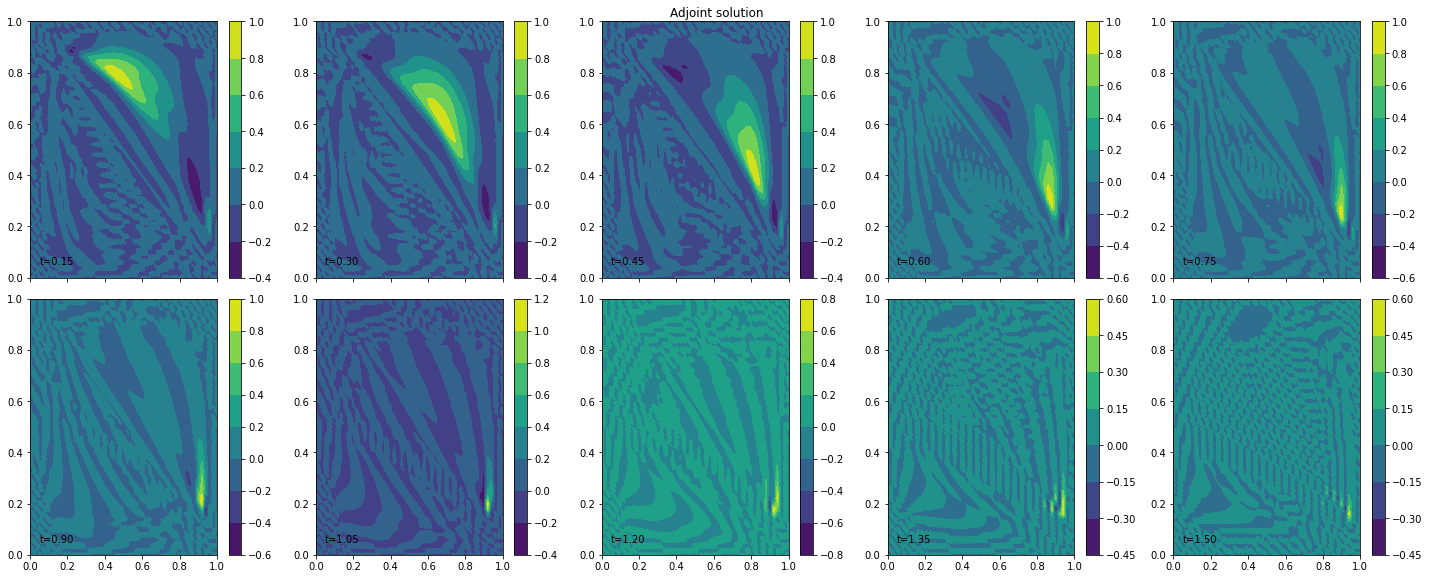

In [4]:
fig, axes, tcs = plot_field(
    solutions, time_partition, "u", "adjoint", cmap='viridis', rows=rows, cols=cols)
plt.suptitle("Adjoint solution", ha='center', va='top', y=1.0)

In [5]:
# print(len(solutions['u']))
# print(solutions['u'].keys())
# print(len(solutions['u']['forward']))
# print(len(solutions['u']['forward'][0]))

Text(0.5, 1.0, 'DWR Indicators')

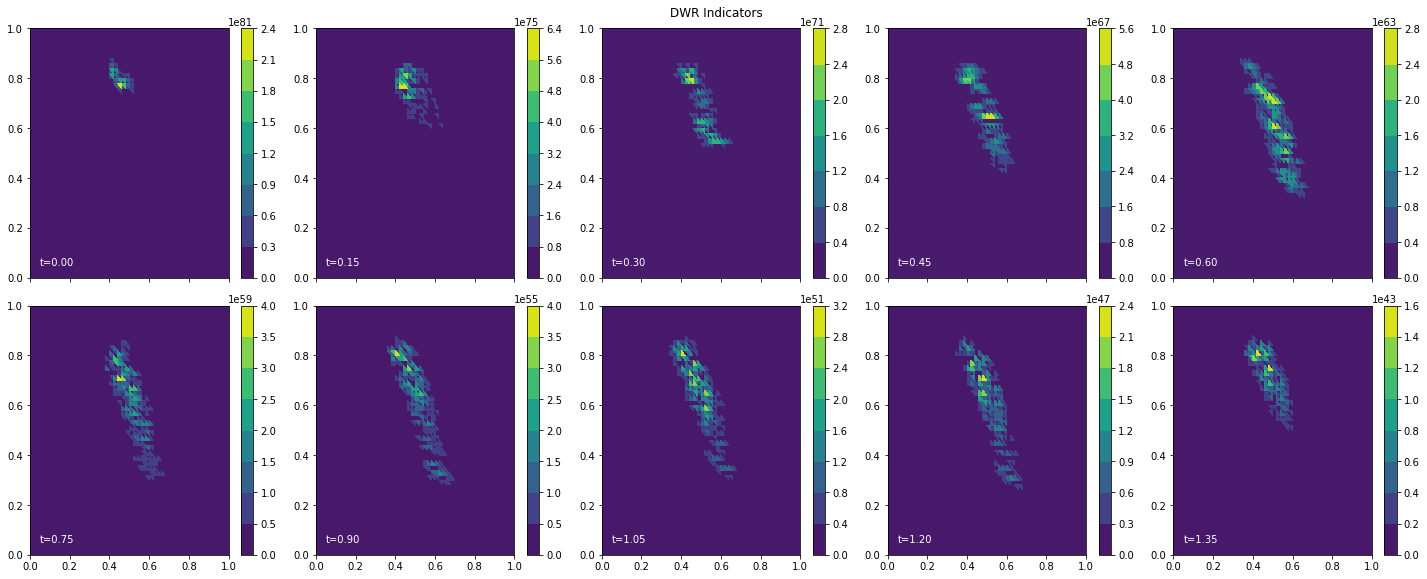

In [6]:
def plot_indicators(indicators, time_partition, **kwargs):
    P = time_partition
    rows = kwargs.pop('rows', (P.exports_per_subinterval[0] - 1) // 2)
    cols = kwargs.pop('cols', (P.num_subintervals * 2))
    steady = rows == cols == 1
#     print(rows, cols)
    dt = P.timesteps[0]
    figsize = kwargs.pop("figsize", (4 * cols, 4 * rows))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(indicators[0][idx], axes=ax, **kwargs))
            if not steady:
                time = idx * dt * timesteps_per_export
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
            fig.colorbar(tc[-1], ax=ax)
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

fig, axs, tcs = plot_indicators(indicators, time_partition, rows=rows, cols=cols)
plt.suptitle("DWR Indicators", ha='center', va='top', y=1.0)

## Define Monitor Function

Text(0.5, 1.0, 'Monitor Function')

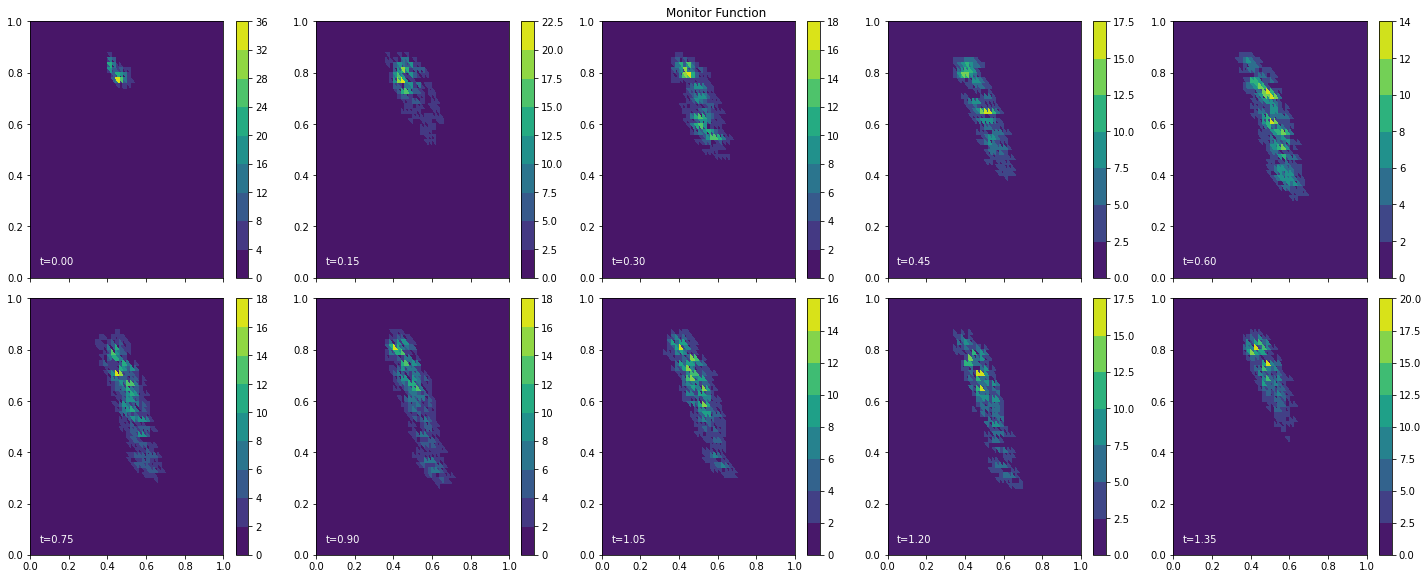

In [7]:
def standardize(arr):
    """
    Apply standardization based on mean and standard deviation
    """
    normed = (arr - np.mean(arr)) / np.std(arr)
    normed -= np.min(normed)
    normed += 1
    return normed

def lp_normalize(arr, p=2):
    """
    Normalize in L^p space.
    """
    retval = arr**p
    denom = sum(retval) ** (1 / p)
    retval /= denom
    return retval



p = 1
standardized_indicators = []
normalized_indicators = []
P0 = FunctionSpace(mesh_seq[0], "DG", 0)
for i in range(len(indicators)):
    t1 = []
    t2 = []
    for j in range(len(indicators[0])):
        t1.append(Function(P0, val=standardize(indicators[i][j].dat.data)))
        t2.append(Function(P0, val=lp_normalize(indicators[i][j].dat.data, p=p)))
    standardized_indicators.append(t1)
    normalized_indicators.append(t2)

fig, axs, tcs = plot_indicators(standardized_indicators, time_partition, rows=rows, cols=cols)
plt.suptitle("Monitor Function", ha='center', va='top', y=1.0)

In [8]:
import time
meshes = [UnitSquareMesh(n, n, diagonal='left') for i in range(len(indicators[0]))]
num_subintervals = len(meshes)
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=1
)
def get_get_monitor(mesh, i, indicators):
    def get_monitor(mesh):
        P0 = FunctionSpace(mesh, "DG", 0)
        f = Function(P0)
        f.project(indicators[0][i])
        return f
    return get_monitor
start = time.time()
lap = start
for i, mesh in enumerate(meshes):
    print("Starting on mesh {}".format(i))
    get_mon = get_get_monitor(mesh, i, standardized_indicators)
    mover = MongeAmpereMover(mesh, get_mon, method="quasi_newton", maxiter=100, rtol=5e-3)
    mover.move();
    print("Took: {:.4f}s".format(time.time() - lap))
    lap = time.time()
print("Overall took {:.4f}s".format(time.time() - start))

Starting on mesh 0
   0   Min/Max 1.1560e-01   Residual 4.0206e-01   Equidistribution 9.9827e-01
   1   Min/Max 9.8220e-02   Residual 4.9130e-01   Equidistribution 9.9801e-01
   2   Min/Max 9.9258e-02   Residual 4.0447e-01   Equidistribution 9.9809e-01
   3   Min/Max 1.1811e-01   Residual 3.2800e-01   Equidistribution 9.9842e-01
   4   Min/Max 1.0594e-01   Residual 2.9338e-01   Equidistribution 9.9853e-01
   5   Min/Max 9.2865e-02   Residual 2.4644e-01   Equidistribution 9.9875e-01
   6   Min/Max 1.1519e-01   Residual 1.8031e-01   Equidistribution 9.9898e-01
Converged in 6 iterations.
Took: 29.5336s
Starting on mesh 1
   0   Min/Max 5.3272e-02   Residual 7.9869e-01   Equidistribution 9.9625e-01
   1   Min/Max 1.4124e-01   Residual 4.0755e-01   Equidistribution 9.9880e-01
   2   Min/Max 9.9767e-02   Residual 3.2206e-01   Equidistribution 9.9863e-01
   3   Min/Max 1.6124e-01   Residual 2.3558e-01   Equidistribution 9.9912e-01
   4   Min/Max 1.7198e-01   Residual 1.6668e-01   Equidistribu

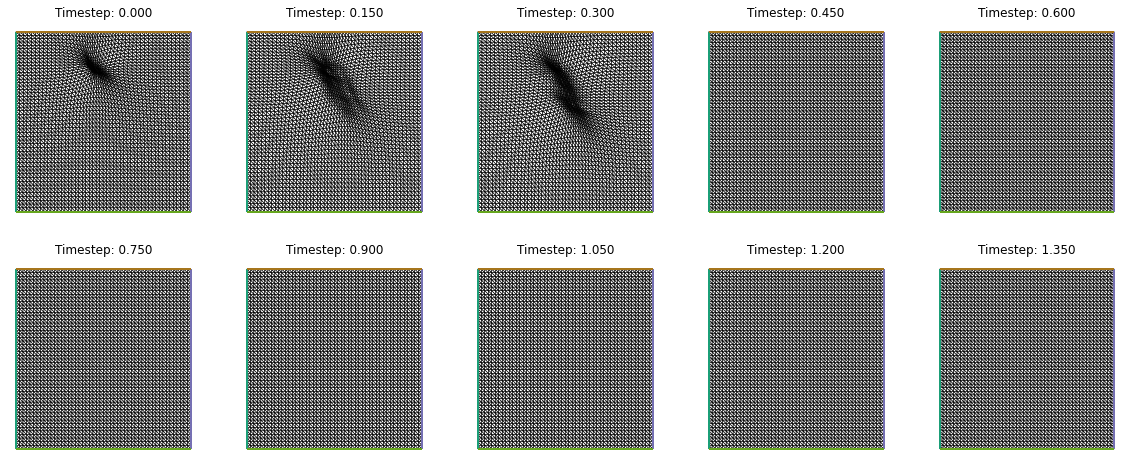

In [9]:
def plot_mesh(mesh, fig=None, axes=None, time_partition=None, **kwargs):
    kwargs.setdefault("interior_kw", {"linewidth": 0.5})
    kwargs.setdefault("boundary_kw", {"linewidth": 2.0})
    if fig is None and axes is None:
        fig, axes = plt.subplots(figsize=(5, 5))
    tp = triplot(mesh, axes=axes, **kwargs)
    axes.axis(False)
    return fig, axes, tp


fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
tps = []
tp = []
for i in range(len(meshes)):
    row, col = i // (len(meshes) // rows), i % cols
    _, _, plot = plot_mesh(meshes[i], fig=fig, axes=axs[row, col])
    tp.append(plot)
    if time_partition is not None:
        time = i * dt * timesteps_per_export
        axs[row, col].set_title("Timestep: {:.3f}".format(time))
tps.append(tp)
# fig.tight_layout(pad=0.5)
# plt.suptitle("Adapted meshes")

In [10]:
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions, indicators = mesh_seq.indicate_errors()
print("New QOI: {:.5f}".format(mesh_seq.J))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


WARNING MeshSeq: Adjoint solution for field u on 0th subinterval is zero.
WARNING MeshSeq: Adjoint action for field u on 0th subinterval is zero.


New QOI: 0.84340


2 5


Text(0.5, 1.0, 'Forward solution after adapt')

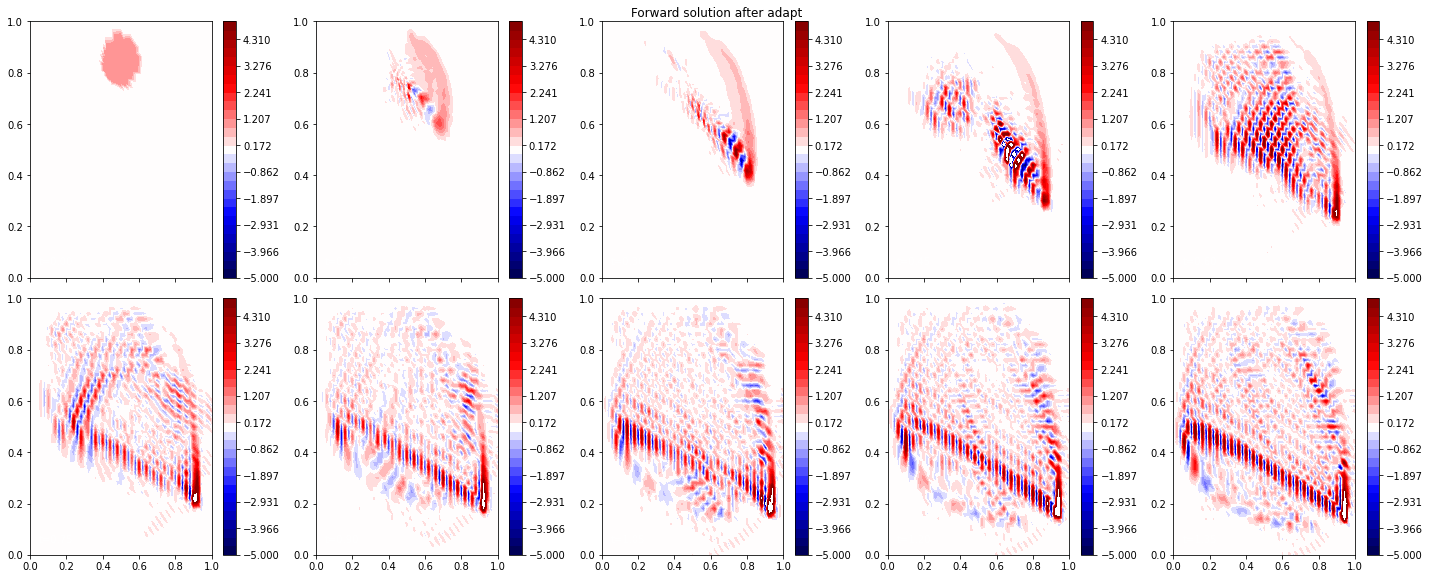

In [11]:
# print("New QOI: {:.5f}".format(mesh_seq.J))
def plot_field2(solutions, time_partition, field="u", label="forward", rows=None, cols=None, **kwargs):
    P = time_partition
    if rows is None or cols is None:
        rows = (P.exports_per_subinterval[0] - 1) // 2
        cols = (P.num_subintervals * 2)
    steady = rows == cols == 1
    print(rows, cols)
    dt = P.timesteps[0]
    figsize = kwargs.pop("figsize", (4 * cols, 4 * rows))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(solutions[field][label][idx][0], axes=ax, **kwargs))
            if not steady:
                time = idx * dt * timesteps_per_export
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
            fig.colorbar(tc[-1], ax=ax)
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

# print(len(solutions))
# print(len(solutions['u']['forward']))
# print(len(solutions['u']['forward'][0]))

fig, axes, tcs = plot_field2(
    solutions, time_partition, "u", "forward_old", cmap='seismic',
    vmin=vmin, vmax=vmax, rows=rows, cols=cols, levels=np.linspace(vmin, vmax, 30))
plt.suptitle("Forward solution after adapt", ha='center', va='top', y=1.0)

Text(0.5, 1.0, 'DWR Indicators after adapt')

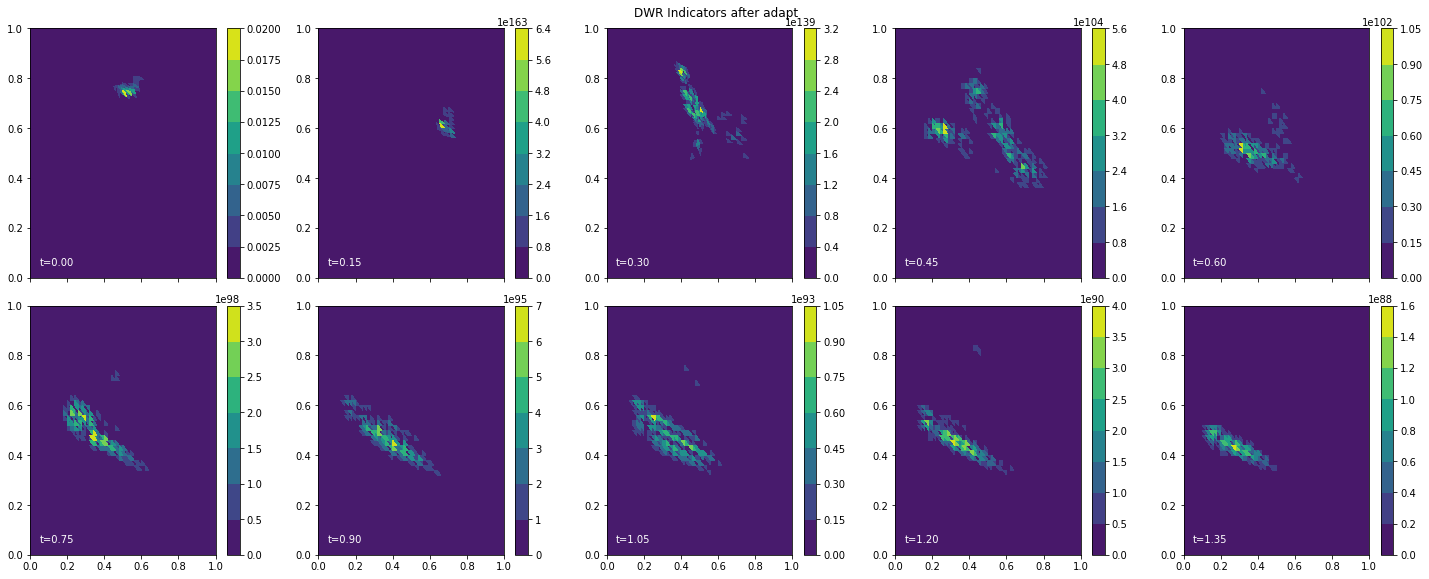

In [12]:
def reorder_indicators(indicators):
    temp = [k[0] for k in indicators]
    temp_indicators = [temp]
    return temp_indicators
t_indicators = reorder_indicators(indicators)
fig, axs, tcs = plot_indicators(t_indicators, time_partition, rows=rows, cols=cols)
plt.suptitle("DWR Indicators after adapt", ha='center', va='top', y=1.0)

In [14]:
print("Computing quality metrics")
quality_measures = {}
for i, mesh in enumerate(meshes):
    quality_measures[i] = {}
    quality_measures[i]["min_angle"] = get_min_angles2d(mesh)
    quality_measures[i]["aspect_ratio"] = get_aspect_ratios2d(mesh)
    quality_measures[i]["skewness"] = get_skewnesses2d(mesh)
    quality_measures[i]["scaled_jac"] = get_scaled_jacobians2d(mesh)
#     print("Mesh {}".format(i))
#     print("Metric\t\tMin\t\tMax")
    for key in quality_measures[i].keys():
        print(
            "{}\t\t\t{:.3f}\t\t\t{:.3f}".format(
                key,
                np.min(quality_measures[i][key].dat.data),
                np.max(quality_measures[i][key].dat.data),
            )
        )

Computing quality metrics
min_angle			0.230			1.038
aspect_ratio			1.000			6.153
skewness			0.007			1.232
scaled_jac			0.228			0.862
min_angle			0.178			1.043
aspect_ratio			1.000			11.507
skewness			0.006			1.307
scaled_jac			0.177			0.864
min_angle			0.156			1.019
aspect_ratio			1.001			8.205
skewness			0.036			1.324
scaled_jac			0.155			0.852
min_angle			0.153			1.043
aspect_ratio			1.000			8.322
skewness			0.004			1.325
scaled_jac			0.152			0.864
min_angle			0.161			1.025
aspect_ratio			1.000			5.588
skewness			0.024			1.291
scaled_jac			0.161			0.854
min_angle			0.169			1.027
aspect_ratio			1.001			7.074
skewness			0.030			1.295
scaled_jac			0.169			0.856
min_angle			0.257			0.996
aspect_ratio			1.003			4.993
skewness			0.055			1.181
scaled_jac			0.255			0.839
min_angle			0.208			1.010
aspect_ratio			1.003			8.141
skewness			0.048			1.270
scaled_jac			0.206			0.847
min_angle			0.146			1.024
aspect_ratio			1.001			11.919
skewness			0.040			1.350
scaled_jac			0.146			0.854
min_angle

In [13]:
# for key in quality_measures[0].keys():
#     out_file = File(f"quality_measures/{key}.pvd")
#     for i in range(len(meshes)):
#         out_file.write(quality_measures[i][key])
#     print("Wrote to {}".format(out_file))

Wrote to <pyroteus.utility.File object at 0x7f770f6f80b8>
Wrote to <pyroteus.utility.File object at 0x7f770ed292b0>
Wrote to <pyroteus.utility.File object at 0x7f770ed0ef60>
Wrote to <pyroteus.utility.File object at 0x7f770eada8d0>


## Re-run the adaptation

Text(0.5, 1.0, 'Monitor Function')

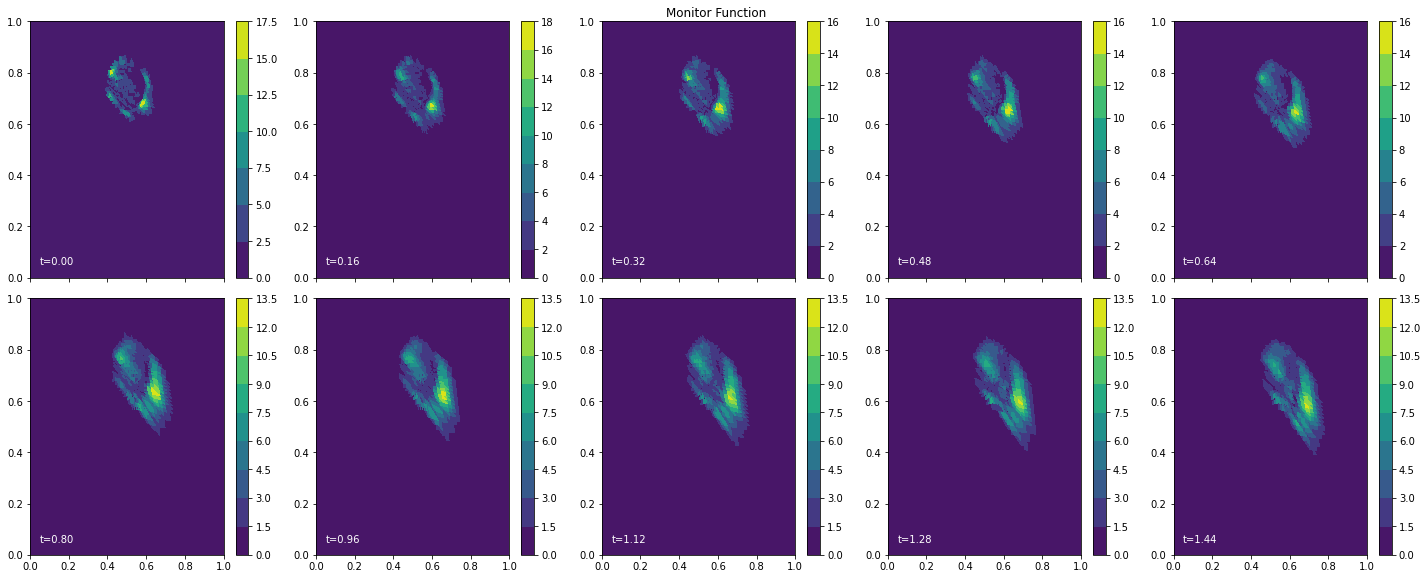

In [15]:
standardized_indicators = []
P0 = FunctionSpace(mesh_seq[0], "DG", 0)
for i in range(len(indicators)):
    t1 = []
    t2 = []
    for j in range(len(indicators[0])):
        t1.append(Function(P0, val=standardize(indicators[i][j].dat.data)))
    standardized_indicators.append(t1)

fig, axs, tcs = plot_indicators(standardized_indicators, time_partition, rows=rows, cols=cols)
plt.suptitle("Monitor Function", ha='center', va='top', y=1.0)

In [17]:
import time as time_m
def get_get_monitor(mesh, i, indicators):
    def get_monitor(mesh):
        P0 = FunctionSpace(mesh, "DG", 0)
        f = Function(P0)
        f.project(indicators[0][i])
        return f
    return get_monitor
start = time_m.time()
lap = start
for i, mesh in enumerate(meshes):
    print("Starting on mesh {}".format(i))
    get_mon = get_get_monitor(mesh, i, standardized_indicators)
    mover = MongeAmpereMover(mesh, get_mon, method="quasi_newton", maxiter=100, rtol=5e-3)
    mover.move();
    print("Took: {:.4f}s".format(time_m.time() - lap))
    lap = time_m.time()
print("Overall took {:.4f}s".format(time_m.time() - start))

Starting on mesh 0
   0   Min/Max 6.5833e-02   Residual 4.3807e-01   Equidistribution 9.9815e-01
   1   Min/Max 9.0556e-02   Residual 9.3260e-02   Equidistribution 9.9942e-01
Converged in 1 iterations.
Took: 0.8383s
Starting on mesh 1
   0   Min/Max 1.0123e-01   Residual 3.7227e-01   Equidistribution 9.9879e-01
   1   Min/Max 6.7041e-02   Residual 2.2195e-01   Equidistribution 9.9935e-01
Converged in 1 iterations.
Took: 8.5754s
Starting on mesh 2
   0   Min/Max 8.9318e-02   Residual 4.8451e-01   Equidistribution 9.9863e-01
   1   Min/Max 1.3550e-01   Residual 3.0931e-01   Equidistribution 9.9937e-01
   2   Min/Max 1.4030e-01   Residual 2.1930e-01   Equidistribution 9.9946e-01
Converged in 2 iterations.
Took: 10.2867s
Starting on mesh 3
   0   Min/Max 8.3872e-02   Residual 5.6740e-01   Equidistribution 9.9854e-01
   1   Min/Max 1.5338e-01   Residual 3.5268e-01   Equidistribution 9.9938e-01
   2   Min/Max 1.6968e-01   Residual 2.4794e-01   Equidistribution 9.9947e-01
Converged in 2 itera

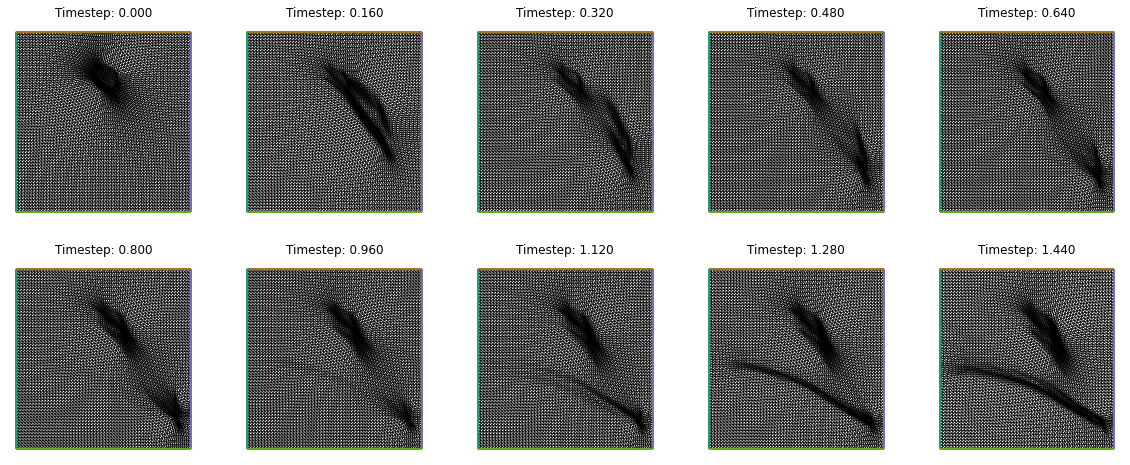

In [19]:
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
tps = []
tp = []
for i in range(len(meshes)):
    row, col = i // (len(meshes) // rows), i % cols
    _, _, plot = plot_mesh(meshes[i], fig=fig, axes=axs[row, col])
    tp.append(plot)
    if time_partition is not None:
        time = i * dt * timesteps_per_export
        axs[row, col].set_title("Timestep: {:.3f}".format(time))
tps.append(tp)

In [18]:
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions, indicators = mesh_seq.indicate_errors()
print("New QOI: {:.5f}".format(mesh_seq.J))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
New QOI: 0.63931


2 5


Text(0.5, 1.0, 'Forward solution after adapt #2')

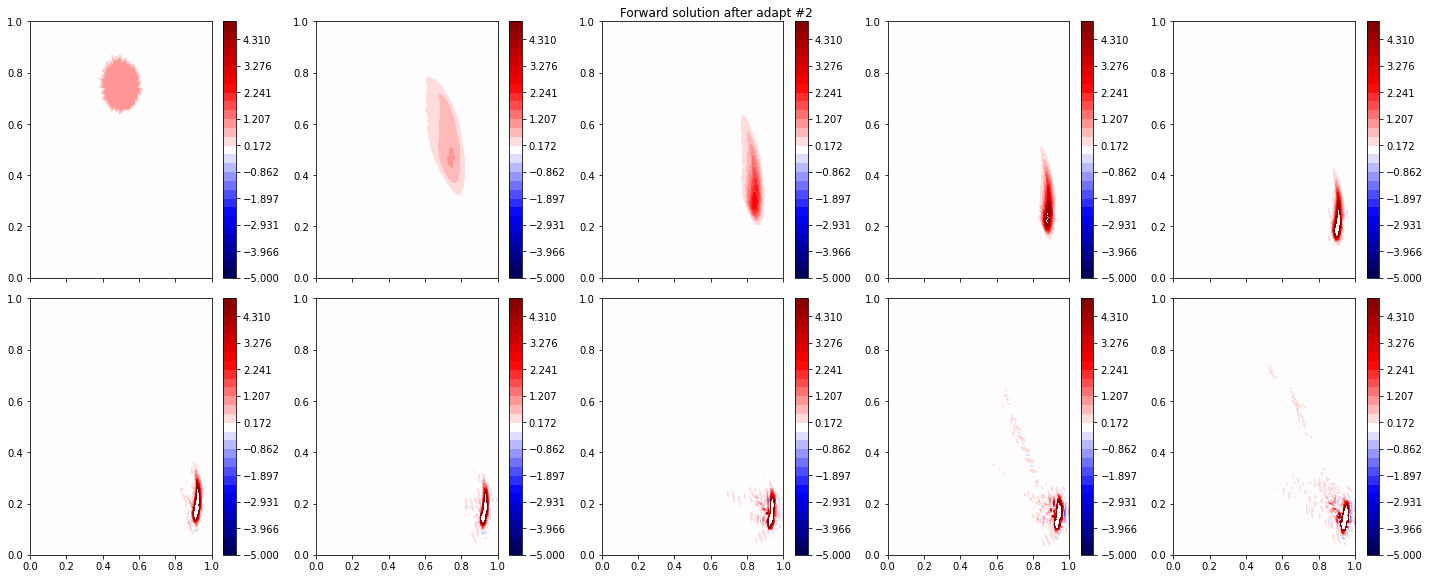

In [22]:
fig, axes, tcs = plot_field2(
    solutions, time_partition, "u", "forward_old", cmap='seismic',
    vmin=vmin, vmax=vmax, rows=rows, cols=cols, levels=np.linspace(vmin, vmax, 30))
plt.suptitle("Forward solution after adapt #2", ha='center', va='top', y=1.0)

Text(0.5, 1.0, 'DWR Indicators after adapt #2')

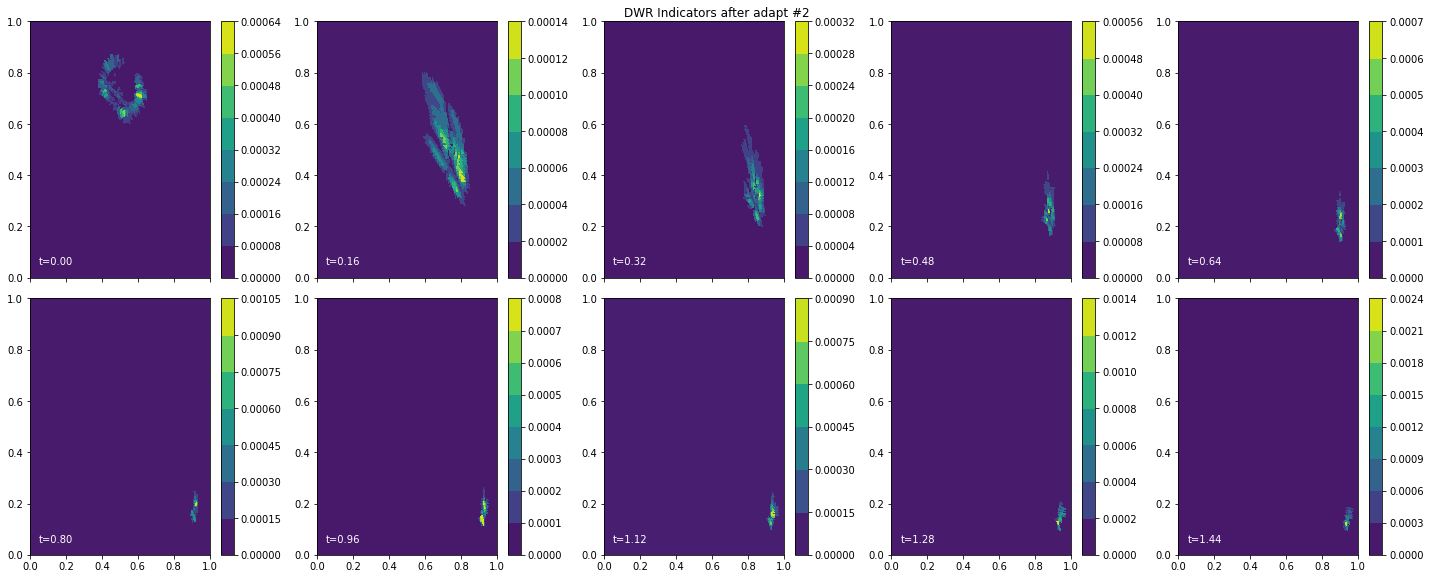

In [21]:
t_indicators = reorder_indicators(indicators)
fig, axs, tcs = plot_indicators(t_indicators, time_partition, rows=rows, cols=cols)
plt.suptitle("DWR Indicators after adapt #2", ha='center', va='top', y=1.0)

In [27]:
# indicators = reorder_indicators(indicators)
standardized_indicators = []
P0 = FunctionSpace(mesh_seq[0], "DG", 0)
for i in range(len(indicators)):
    t1 = []
    t2 = []
    for j in range(len(indicators[0])):
        t1.append(Function(P0, val=standardize(indicators[i][j].dat.data)))
    standardized_indicators.append(t1)


1
